In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, Resizing, Rescaling, GlobalAveragePooling2D, Permute)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [3]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Avoid memory overflow

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data_dir_train = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/SkinDisease/SkinDisease/train"
data_dir_test = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/SkinDisease/SkinDisease/test"

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=8,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
)

Found 13898 files belonging to 22 classes.


In [6]:
class_names = train_data.class_names
print("Class Names:", class_names)

Class Names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [7]:
test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    batch_size=8  # Match batch size
)

Found 1546 files belonging to 22 classes.


In [8]:
train_data_itr = train_data.as_numpy_iterator()
batch = train_data_itr.next()

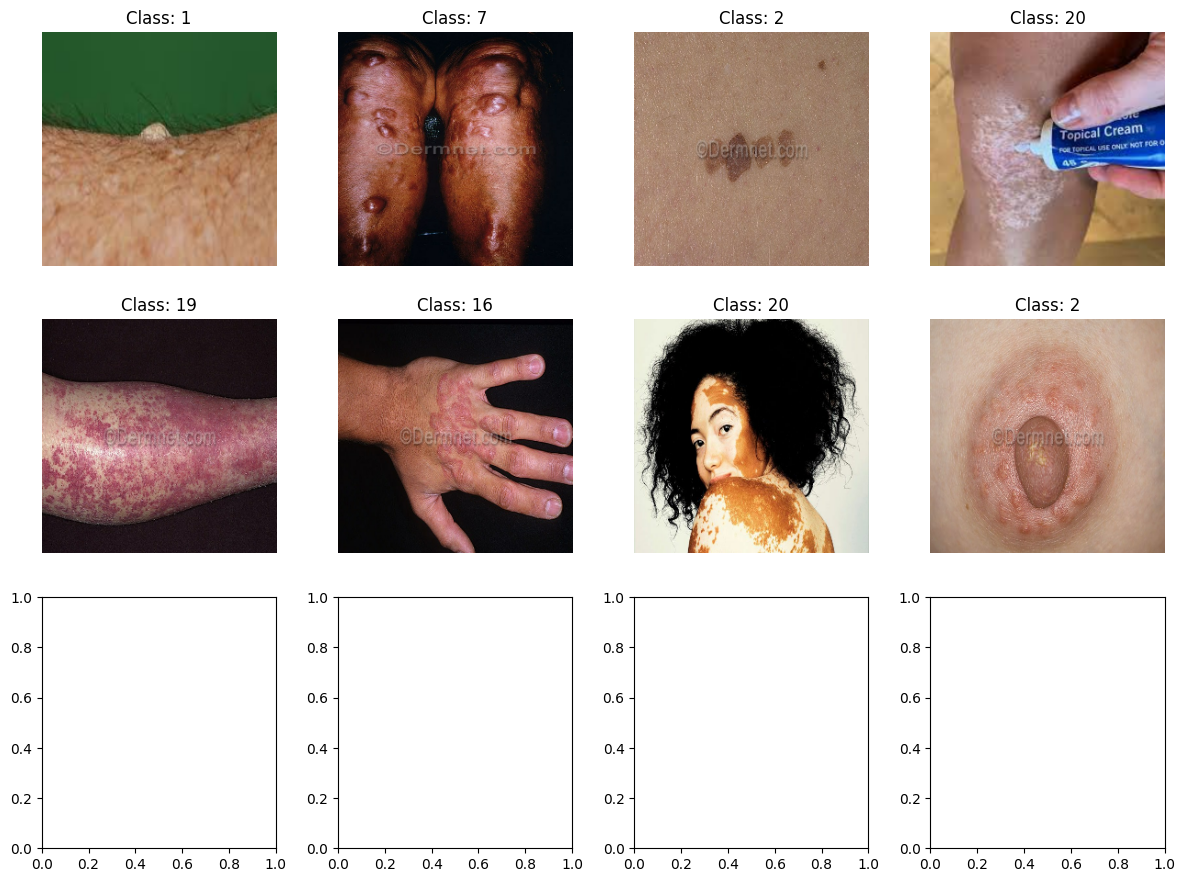

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))  # 3x4 grid

for idx, img in enumerate(batch[0][:12]):  # Show first 12 images
    row = idx // 4
    col = idx % 4
    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(f"Class: {batch[1][idx]}")
    ax[row, col].axis("off")


plt.tight_layout()
plt.show()

In [10]:
train_dataset = train_data.prefetch(tf.data.AUTOTUNE)
val_dataset = test_data.prefetch(tf.data.AUTOTUNE)

In [11]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(192, 192),
    Rescaling(1./255),
    Permute((3, 1, 2))  # Keep the format consistent with ViT
])


In [12]:
train_dataset = train_data.prefetch(tf.data.AUTOTUNE)
val_dataset = test_data.prefetch(tf.data.AUTOTUNE)

In [13]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1./255),
    Permute((3, 1, 2))  # Keep the format consistent with ViT
])

In [14]:
metrics=[ SparseCategoricalAccuracy( name ="accuracy"), SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy")]

In [15]:
from transformers import ViTFeatureExtractor, TFViTModel
base_model=TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs=Input(shape=(256,256,3))

x= resize_rescale_hf(inputs)
x=base_model.vit(x)[0][:,0,:]
outputs=Dense(23,activation="softmax")(x)
hf_model=tf.keras.Model(inputs=inputs,outputs=outputs)

c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [16]:
hf_model.compile(Adam(learning_rate=5e-5), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[metrics])
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (De

In [17]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0,
)

In [18]:
vit_history = hf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[plateau_callback]
)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model/vit/encoder/layer_._6/layernorm_before/batchnorm/mul_2' defined at (most recent call last):
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\karti\AppData\Local\Temp\ipykernel_14008\2764529509.py", line 1, in <module>
      vit_history = hf_model.fit(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\transformers\modeling_tf_utils.py", line 504, in run_call_with_unpacked_inputs
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 517, in call
      encoder_outputs = self.encoder(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 436, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 440, in call
      layer_outputs = layer_module(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 392, in call
      attention_outputs = self.attention(
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\karti\anaconda3\envs\tf_skin\lib\site-packages\keras\layers\normalization\layer_normalization.py", line 296, in call
      outputs = tf.nn.batch_normalization(
Node: 'model/vit/encoder/layer_._6/layernorm_before/batchnorm/mul_2'
failed to allocate memory
	 [[{{node model/vit/encoder/layer_._6/layernorm_before/batchnorm/mul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_36554]

In [ ]:
plt.plot(vit_history.history['loss'])
plt.plot(vit_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [ ]:
plt.plot(vit_history.history['accuracy'])
plt.plot(vit_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()